In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%matplotlib inline

## Уравнения модели

Модель хищник-жертва (Lotka–Volterra equations) описывается следующими уравнениями
$$
\begin{cases}
    \dot x = \alpha x - \beta x y, \\
    \dot y = \delta x y - \gamma y, \\
\end{cases}
$$
где $x(t)$ - популяция жертвы, $y(t)$ - популяция хищников, $\alpha=0.8$, $\beta=1.2$, $\gamma=1.2$, $\delta=1.0$

In [3]:
#Lotka–Volterra equations
def predator_prey(x, t, p):
    dx1 = p[0] * x[0] - p[1] * x[0] * x[1]
    dx2 = p[3] * x[0] * x[1] - p[2] * x[1]
    return dx1, dx2

## Решение прямой задачи. Генерация выборки наблюдений

In [4]:
init = [0.99, 0.01]
times = np.arange(0, 10, 0.25)
alpha, beta, gamma, delta = 0.8, 1.2, 1.2, 1.0

In [5]:
y = odeint(predator_prey, t=times, y0=init, args=((alpha, beta, gamma, delta),), rtol=1e-8)

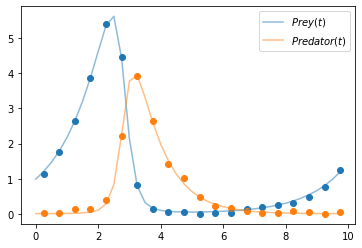

In [6]:
yobs = np.clip(np.random.normal(loc = y[1::], scale = 0.05), a_min = 0, a_max = None)

plt.plot(times[1::2], yobs[::2], marker="o", linestyle="none")
plt.plot(times, y[:, 0], color="C0", alpha=0.5, label=f"$Prey(t)$")
plt.plot(times, y[:, 1], color="C1", alpha=0.5, label=f"$Predator(t)$")
plt.legend()
_ = _

## Решение обратной задачи

In [7]:
lv_model = DifferentialEquation(
    func=predator_prey,
    times=np.arange(0.25, 10, 0.25), 
    n_states=2, 
    n_theta=4,
    t0=0,
)

In [10]:
with pm.Model() as model:
    sigma = pm.HalfCauchy("sigma", 1, shape=2)

    alpha = pm.Uniform("alpha", 0.1, 3.0)
    beta = pm.Uniform("beta", 0.1, 3.0)
    gamma = pm.Uniform("gamma", 0.1, 10.0)

    lv_curves = lv_model(y0=[0.99, 0.01], theta=[alpha, beta, gamma, 1.0])

    Y = pm.Normal("Y", mu=lv_curves, sigma=sigma, observed=yobs)

    trace = pm.sample(80, tune=500, target_accept=0.9, cores=1)
    data = az.from_pymc3(trace=trace)

d:\packprogs\python379conda\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if sys.path[0] == '':
Only 80 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [gamma, beta, alpha, sigma]


Sampling 2 chains for 500 tune and 80 draw iterations (1_000 + 160 draws total) took 2461 seconds.
d:\packprogs\python379conda\lib\site-packages\pymc3\sampling.py:643: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


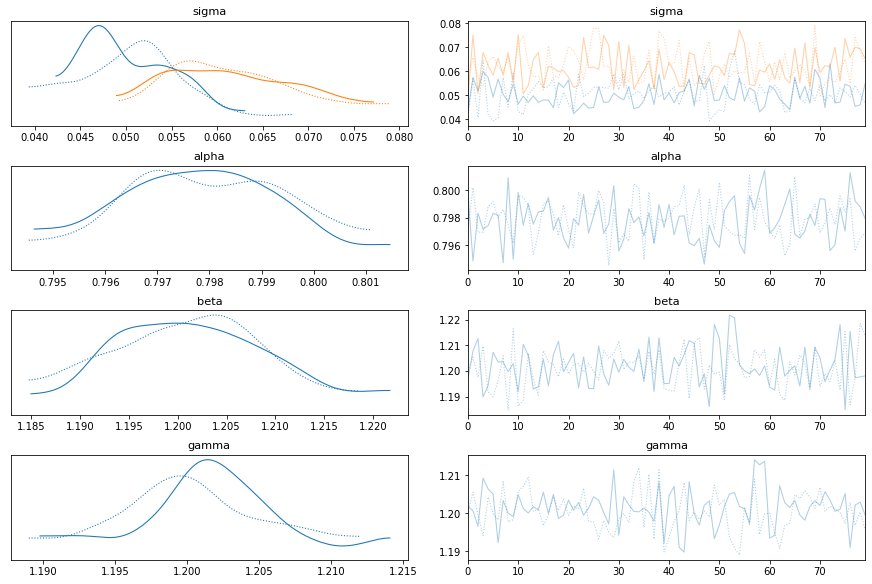

In [11]:
with model:
    az.plot_trace(trace)

array([[<AxesSubplot:title={'center':'sigma\n0'}>,
        <AxesSubplot:title={'center':'sigma\n1'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'gamma'}>, <AxesSubplot:>]],
      dtype=object)

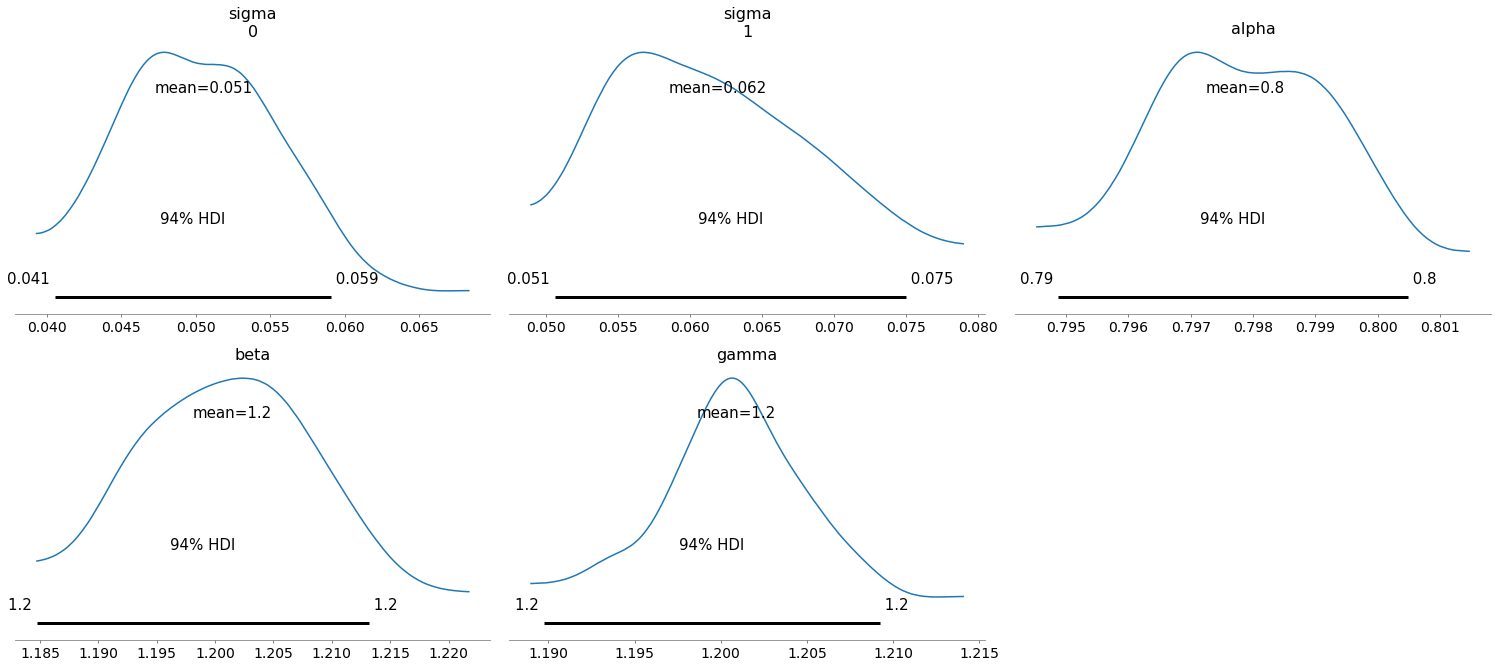

In [12]:
az.plot_posterior(data, round_to=2)